In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.base import clone
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

Funciones para el entrenamiento del modelo:

In [2]:
def split_train_trest(X,y,stratify =None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = stratify, random_state=42)
    return X_train, X_test, y_train, y_test 

def one_hot_encoder(data):
    encoded_data = []
    for dato in data:
        if isinstance(dato, pd.Series):
            dato = pd.DataFrame(dato)
        # Seleccionar las columnas categoricas
        categorical_columns = dato.select_dtypes(include=["object"]).columns
        encoder = OneHotEncoder(sparse = False)
        ## Aplicar One Hot Encoding
        encoded_columns = encoder.fit_transform(dato[categorical_columns])
        # Recuperar el nombre de las columnas
        new_columns = encoder.get_feature_names_out(categorical_columns)
        # Crear un DataFrame con los datos codificados y el nombre de las columnas
        data_encoded = pd.DataFrame(encoded_columns, columns=new_columns)
        # Resetear index
        dato.reset_index(drop=True, inplace=True)
        data_encoded.reset_index(drop=True, inplace=True)
        # Concatenar por columnas ambos DataFrames
        dato_encoded = pd.concat([dato.drop(categorical_columns, axis=1), data_encoded], axis=1)
        # Agregar el DataFrame codificado a la lista
        encoded_data.append(dato_encoded)

    return encoded_data[0], encoded_data[1]

def standardize(X_train,X_test):
    scaler = StandardScaler()
    variables_estandarizar = ["Dormitorios","Superficie","Num_baños","Año_de_construccion","Latitud","Longitud"]
    ##variables_estandarizar = ["Latitud","Longitude"]
    X_train_encoded_scaled = X_train.copy()
    X_test_encoded_scaled = X_test.copy()
    X_train_encoded_scaled[variables_estandarizar] = scaler.fit_transform(X_train[variables_estandarizar])
    X_test_encoded_scaled[variables_estandarizar] = scaler.transform(X_test[variables_estandarizar])
    return X_train_encoded_scaled,X_test_encoded_scaled

def calculate_error(model,X,y):
    test_predictions = model.predict(X)
    test_mse = mean_absolute_error(y, test_predictions)
    return test_mse

Leemos los datos:

In [3]:
datos = pd.read_parquet("C:/Users/dalon/Desktop/UCM/2º/PROYECTO_DATOS_I/preprocesadoFINAL.parquet")
datos

,Precio,Dormitorios,Superficie,Num_baños,Metro,Renfe,Tipo_de_inmueble,Año_de_construccion,Calefaccion,Etiqueta,Aire acondicionado,Ascensor,Jardin,Tipo,distrito/ciudad,Latitud,Longitud
1,133000.0,2.0,122.0,2.0,0.0,0.0,De época,2007.0,0.0,En proceso,1.0,0.0,0.0,piso,Ciempozuelos,40.158009,-3.620551
2,125000.0,2.0,57.0,1.0,0.0,1.0,Señorial,1960.0,0.0,En proceso,0.0,1.0,0.0,piso,San Diego,40.388100,-3.667700
3,170000.0,2.0,50.0,1.0,1.0,0.0,Popular,1974.0,1.0,E,1.0,1.0,0.0,piso,vinateros,40.405197,-3.641547
4,370000.0,3.0,106.0,2.0,1.0,0.0,Popular,1970.0,0.0,E,0.0,1.0,0.0,piso,vinateros,40.405197,-3.641547
5,280000.0,4.0,171.0,2.0,0.0,0.0,Media,1986.0,1.0,En proceso,1.0,0.0,0.0,casa,Mejorada del Campo,40.397179,-3.489607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,279000.0,4.0,70.0,1.0,1.0,0.0,Señorial,1964.0,1.0,E,0.0,1.0,0.0,piso,Concepción,40.439500,-3.647900
2624,209900.0,3.0,113.0,2.0,1.0,0.0,Popular,1984.0,1.0,En proceso,0.0,1.0,0.0,piso,Portazgo,40.391437,-3.648126
2625,949999.0,8.0,909.0,2.0,0.0,1.0,Popular,1930.0,0.0,E,1.0,0.0,0.0,piso,Aranjuez,40.032210,-3.603960
2626,130000.0,2.0,69.0,1.0,1.0,0.0,Media,1958.0,1.0,En proceso,1.0,0.0,0.0,piso,Puerta Bonita,40.381328,-3.739750


Aplicamos el filtro de casas con menos de 300m2 para mejorar el modelo como hemos explicado en la memoria.

In [4]:
filtro = datos["Superficie"] < 300
datos = datos[filtro]
datos["Etiqueta"] = datos["Etiqueta"].replace({"A":"A+"})

C:\Users\dalon\AppData\Local\Temp\ipykernel_8548\2090345290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos["Etiqueta"] = datos["Etiqueta"].replace({"A":"A+"})


Creamos el apaño con la estratificación que hemos explicado en la memoria, hacemos one hot encoding a las variables categóricas y escalamos los datos para que esten listos para la fase de entrenamiento del modelo.

In [5]:
X = datos.drop(columns = "Precio")
y = datos["Precio"]
# Calcular la mediana de la superficie por localización
mediana_precio_localizacion = datos.groupby("distrito/ciudad")["Precio"].median()

# Crear una función para etiquetar cada fila según si la superficie es mayor o menor que la mediana local
def etiquetar_superficie(row):
    if row["Precio"] > mediana_precio_localizacion[row["distrito/ciudad"]]:
        return "caro_"
    else:
        return "barato"

# Aplicar la función a cada fila y crear una nueva columna llamada 'estratificacion'
estratificacion = datos.apply(etiquetar_superficie, axis=1)

# Combinar las etiquetas de los bins con las etiquetas de los distritos/ciudades
estratificacion_final = estratificacion + '_' + datos["distrito/ciudad"]
stratify = estratificacion_final
X_train, X_test, y_train, y_test = split_train_trest(X,y,stratify)
X_train_encoded, X_test_encoded= one_hot_encoder([X_train, X_test])
X_train_encoded_scaled,X_test_encoded_scaled = standardize(X_train_encoded, X_test_encoded)

Creamos la variable "kfold" para que siempre se hagan las mismas divisiones al hacer cross validation.

In [6]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)

## DECISSION TREE REGRESSOR

Probamos una primera aproximación con el modelo de "Decission Tree Regressor" con todos los parámetros por defecto, para ver con lo que estamos trabajando.

In [16]:
clr = DecisionTreeRegressor(random_state = 42)
clr.fit(X_train_encoded_scaled, y_train)
calculate_error(clr,X_test_encoded_scaled,y_test)

50672.17731958763

### GridSearchCV

#### Intento 1

In [43]:
param_grid = {
    'max_depth':[None, 5, 10, 25],
    'min_samples_split':[4,7,10],
    'min_weight_fraction_leaf':[0.1,0.2,0.3],
    'max_features':[None,'sqrt','log2'],
    'min_impurity_decrease':[0.0,0.01,0.1]
}
dt_regressor = DecisionTreeRegressor(random_state = 42)
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', n_jobs = -1)
grid_search.fit(X_train_encoded_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 25],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_impurity_decrease': [0.0, 0.01, 0.1],
                         'min_samples_split': [4, 7, 10],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3]},
             scoring='neg_mean_absolute_error')

In [44]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada (neg_mean_squared_error): {:.2f}".format(-grid_search.best_score_))

Mejores parámetros encontrados:
{'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1}
Mejor puntuación de validación cruzada (neg_mean_squared_error): 67548.12


In [45]:
calculate_error(grid_search.best_estimator_, X_test_encoded_scaled, y_test)

62844.79060177689

In [46]:
calculate_error(grid_search.best_estimator_, X_train_encoded_scaled, y_train)

65417.25469534284

Podemos ver que hay un claro subajuste, vamos a hacer otro intento.

#### Intento 2

In [51]:
param_grid = {
    'max_depth':[None, 5, 10, 25],
    'min_samples_split':[2,4,7],
    'min_weight_fraction_leaf':[0.01,0.05,0.1],
    'max_features':[None,'sqrt', 0.5],
    'min_impurity_decrease':[0.0,0.01,0.1]
}
dt_regressor = DecisionTreeRegressor(random_state = 42)
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', n_jobs = -1)
grid_search.fit(X_train_encoded_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 25],
                         'max_features': [None, 'sqrt', 0.5],
                         'min_impurity_decrease': [0.0, 0.01, 0.1],
                         'min_samples_split': [2, 4, 7],
                         'min_weight_fraction_leaf': [0.01, 0.05, 0.1]},
             scoring='neg_mean_absolute_error')

In [52]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada (neg_mean_squared_error): {:.2f}".format(-grid_search.best_score_))

Mejores parámetros encontrados:
{'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.01}
Mejor puntuación de validación cruzada (neg_mean_squared_error): 58024.81


In [53]:
calculate_error(grid_search.best_estimator_, X_test_encoded_scaled, y_test)

50692.43923977819

In [54]:
calculate_error(grid_search.best_estimator_, X_train_encoded_scaled, y_train)

43791.636192424274

In [76]:
dtr_best_grid = DecisionTreeRegressor(max_depth= None, max_features= None, min_impurity_decrease= 0.0, min_samples_split= 2, min_weight_fraction_leaf= 0.01, random_state = 42)
dtr_best_grid.fit(X_train_encoded_scaled, y_train)

DecisionTreeRegressor(min_weight_fraction_leaf=0.01, random_state=42)

El error ha mejorado enormemente y ya no hay ni subajuste ni sobreajuste.

### RandomizedSearchCV

In [59]:
param_dist = {
    'max_depth': [None,  randint(5,40)],
    "min_samples_split":  randint(2, 10),
    'min_weight_fraction_leaf': [random.uniform(0.0, 0.2)],
    "max_features": [None,'sqrt', 'log2'],
    'min_impurity_decrease': [random.uniform(0.0, 0.1)]
}
dt_regressor = DecisionTreeRegressor(max_depth = 6, random_state = 42)
random_search = RandomizedSearchCV(dt_regressor, param_distributions=param_dist, n_iter=800, cv=kfold,scoring='neg_mean_absolute_error', random_state=42)

# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
random_search.fit(X_train_encoded_scaled, y_train)

C:\Users\dalon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1925 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1925 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dalon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dalon\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1315, in fit
    super().fit(
  File "C:\Users\dalon\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 305, in fit
    if max_depth <= 0:
TypeError: '<=' not supported between instances of 'rv_discrete_frozen' a

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeRegressor(max_depth=6,
                                                   random_state=42),
                   n_iter=800,
                   param_distributions={'max_depth': [None,
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_impurity_decrease': [0.05835927577054006],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020160CA2DF0>,
                                        'min_weight_fraction_leaf': [0.09543286400591243]},
                   random_state=42, scoring='neg_mean_absolute_error')

In [60]:
print("Mejores parámetros encontrados:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada (neg_mean_squared_error): {:.2f}".format(-random_search.best_score_))

Mejores parámetros encontrados:
{'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.05835927577054006, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.09543286400591243}
Mejor puntuación de validación cruzada (neg_mean_squared_error): 67554.09


In [61]:
calculate_error(random_search.best_estimator_, X_test_encoded_scaled, y_test)

62539.15950896476

In [62]:
calculate_error(random_search.best_estimator_, X_train_encoded_scaled, y_train)

65289.19021652985

---
## RANDOM FOREST

In [20]:
random_forest = RandomForestRegressor(random_state = 42)
random_forest.fit(X_train_encoded_scaled, y_train)
print(calculate_error(random_forest,X_test_encoded_scaled,y_test))
print(calculate_error(random_forest,X_train_encoded_scaled,y_train))

38673.36310554737
16668.074506336576


### GridSearchCV

#### Intento1

In [8]:
param_grid = {
    'n_estimators':[50,100,200,300],
    'max_depth':[None, 5, 10, 25],
    'min_samples_split':[4,7,10],
    'min_weight_fraction_leaf':[0.1,0.2,0.3],
    'max_features':[None,'sqrt', 0.5],
    'min_impurity_decrease':[0.0,0.01,0.1]
}
rf_regressor = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', n_jobs = -1)
grid_search.fit(X_train_encoded_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 25],
                         'max_features': [None, 'sqrt', 0.5],
                         'min_impurity_decrease': [0.0, 0.01, 0.1],
                         'min_samples_split': [4, 7, 10],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='neg_mean_absolute_error')

In [9]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada (neg_mean_squared_error): {:.2f}".format(-grid_search.best_score_))

Mejores parámetros encontrados:
{'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1, 'n_estimators': 100}
Mejor puntuación de validación cruzada (neg_mean_squared_error): 63414.09


In [10]:
calculate_error(grid_search.best_estimator_, X_test_encoded_scaled, y_test)

59232.895869485845

In [11]:
calculate_error(grid_search.best_estimator_, X_train_encoded_scaled, y_train)

62234.915780352174

Podemos ver que hay un claro subajuste, vamos a hacer otro intento.

#### Intento 2

Vamos a probar valores que permitan la construcción de árboles más complejos:

In [12]:
param_grid = {
    'n_estimators':[50,100,200,300],
    'max_depth':[None, 5, 10, 25],
    'min_samples_split':[2,4,7],
    'min_weight_fraction_leaf':[0.01,0.05,0.1],
    'max_features':[None,'sqrt', 0.5],
    'min_impurity_decrease':[0.0,0.01,0.1]
}
rf_regressor = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', n_jobs = -1)
grid_search.fit(X_train_encoded_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 25],
                         'max_features': [None, 'sqrt', 0.5],
                         'min_impurity_decrease': [0.0, 0.01, 0.1],
                         'min_samples_split': [2, 4, 7],
                         'min_weight_fraction_leaf': [0.01, 0.05, 0.1],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='neg_mean_absolute_error')

In [13]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada (neg_mean_squared_error): {:.2f}".format(-grid_search.best_score_))

Mejores parámetros encontrados:
{'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 100}
Mejor puntuación de validación cruzada (neg_mean_squared_error): 49777.53


In [14]:
calculate_error(grid_search.best_estimator_, X_test_encoded_scaled, y_test)

43913.20550419836

In [15]:
calculate_error(grid_search.best_estimator_, X_train_encoded_scaled, y_train)

38764.74638784999

In [78]:
rf_best_grid = RandomForestRegressor(max_depth= None, max_features= None, min_impurity_decrease= 0.0, min_samples_split= 2, min_weight_fraction_leaf= 0.01, n_estimators= 100, random_state = 42)
rf_best_grid.fit(X_train_encoded_scaled, y_train)

RandomForestRegressor(max_features=None, min_weight_fraction_leaf=0.01,
                      random_state=42)

El modelo ha mejorado enormemente, pero vamos a jugar un poco más con los parámetros para ver si podemos mejorarlo un poco más:

#### Intento 3

Vamos a limitar los valores del grid para que cree un modelo con muchos estimadores pero con estimadores simples:

In [30]:
param_grid = {
    'n_estimators':[100,200,300,500],
    'max_depth':[5,10,20],
    'min_samples_split':[3,4,5],
    'min_weight_fraction_leaf':[0.01,0.03,0.05],
    'max_features':['sqrt', 'log2'],
    'min_impurity_decrease':[0.01,0.05,0.1]
}
rf_regressor = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', n_jobs = -1)
grid_search.fit(X_train_encoded_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_impurity_decrease': [0.01, 0.05, 0.1],
                         'min_samples_split': [3, 4, 5],
                         'min_weight_fraction_leaf': [0.01, 0.03, 0.05],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='neg_mean_absolute_error')

In [31]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada (neg_mean_squared_error): {:.2f}".format(-grid_search.best_score_))

Mejores parámetros encontrados:
{'max_depth': 20, 'max_features': 'sqrt', 'min_impurity_decrease': 0.01, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 300}
Mejor puntuación de validación cruzada (neg_mean_squared_error): 64280.19


In [32]:
calculate_error(grid_search.best_estimator_, X_test_encoded_scaled, y_test)

62948.636243113404

In [33]:
calculate_error(grid_search.best_estimator_, X_train_encoded_scaled, y_train)

60628.94664295416

No hay sobreajuste pero el rendimiento del modelo es pésimo debido a la simplicidad de los estimadores.

#### Intento 4

Vamos a limitar los valores del grid para que cree un modelo con pocos estimadores pero con estimadores complejos:

In [26]:
param_grid = {
    'n_estimators':[25,50,75],
    'max_depth':[None, 30, 50],
    'min_samples_split':[2,3,4],
    'min_weight_fraction_leaf':[0.0, 0.001, 0.01],
    'max_features':[None, 'log2'],
    'min_impurity_decrease':[0.0,0.001,0.01]
}
rf_regressor = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=kfold, scoring='neg_mean_absolute_error', n_jobs = -1)
grid_search.fit(X_train_encoded_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 30, 50],
                         'max_features': [None, 'log2'],
                         'min_impurity_decrease': [0.0, 0.001, 0.01],
                         'min_samples_split': [2, 3, 4],
                         'min_weight_fraction_leaf': [0.0, 0.001, 0.01],
                         'n_estimators': [25, 50, 75]},
             scoring='neg_mean_absolute_error')

In [27]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada (neg_mean_squared_error): {:.2f}".format(-grid_search.best_score_))

Mejores parámetros encontrados:
{'max_depth': 30, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50}
Mejor puntuación de validación cruzada (neg_mean_squared_error): 45335.65


In [28]:
calculate_error(grid_search.best_estimator_, X_test_encoded_scaled, y_test)

39258.438487972504

In [29]:
calculate_error(grid_search.best_estimator_, X_train_encoded_scaled, y_train)

16865.18705570292

El error en test ha mejorado un poco, pero a costa de un error en train sospechoso de sobreajuste.

### RandomizedSearchCV

In [70]:
from scipy.stats import randint
import random
param_dist = {
    "n_estimators": randint(50, 300),
    'max_depth': [None,  randint(5,40)],
    "min_samples_split":  randint(2, 10),
    'min_weight_fraction_leaf': [random.uniform(0.0, 0.2)],
    "max_features": [None,'sqrt', 'log2'],
    'min_impurity_decrease': [random.uniform(0.0, 0.1)]
}
rf_regressor = RandomForestRegressor(random_state = 42)
random_search = RandomizedSearchCV(rf_regressor, param_distributions=param_dist, n_iter=100, cv=kfold,scoring='neg_mean_absolute_error', random_state=42)

# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
random_search.fit(X_train_encoded_scaled, y_train)

C:\Users\dalon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dalon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dalon\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\dalon\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\dalon\anaconda3\lib\site-packages

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=42), n_iter=100,
                   param_distributions={'max_depth': [None,
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_impurity_decrease': [0.03891521268810775],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000201606B2040>,
                                        'min_weight_fraction_leaf': [0.08791328633566556],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000201606E7550>},
                   random_state=42, scoring='neg_mean_absolute_error')

In [71]:
print("Mejores parámetros encontrados:")
print(random_search.best_params_)
print("Mejor puntuación de validación cruzada (neg_mean_squared_error): {:.2f}".format(-random_search.best_score_))

Mejores parámetros encontrados:
{'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.03891521268810775, 'min_samples_split': 9, 'min_weight_fraction_leaf': 0.08791328633566556, 'n_estimators': 178}
Mejor puntuación de validación cruzada (neg_mean_squared_error): 62596.93


In [72]:
calculate_error(random_search.best_estimator_, X_test_encoded_scaled, y_test)

58383.79781744973

In [73]:
calculate_error(random_search.best_estimator_, X_train_encoded_scaled, y_train)

61540.40122797156

In [70]:
rf_random_model = RandomForestRegressor(max_depth = 8, max_features= 'sqrt',min_samples_leaf = 1, min_samples_split = 8,n_estimators = 18, random_state = 42)
rf_random_model.fit(X_train_encoded_scaled, y_train)

RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_split=8,
                      n_estimators=18, random_state=42)

## Mejor modelo

- Decission Tree Regressor:
    - Primera aproximación con GridSearch:
        - Error en test: 62844
        - Error en train: 65417
    - GridSearchCV con parámetros más ajustados:
        - Error en test: 50692
        - Error en train: 43791
    - RandomizedSearchCV:
        - Error en test: 62539
        - Error en train: 65289
- Random Forest:
    - Primera aproximación con GridSearch:
        - Error en test: 59232
        - Error en train: 62234
    - GridSearchCV con parámetros más ajustados:
        - Error en test: 43913
        - Error en train: 38764
    - GridSearchCV muchos estimadores simples:
        - Error en test: 62948
        - Error en train: 60628
    - GridSearchCV pocos estimadores complejos:
        - Error en test: 39258
        - Error en train: 16865
    - RandomizedSearchCV:
        - Error en test: 58383
        - Error en train: 61540

Entre los modelos de Decission Tree Regressor podemos ver que el obtenido con GridSearchCV en el intento 2 da el menor error en test y no sobreajusta. Por último el obtenido con RandomizedSearchCV da un error bastante alto. Por lo que el obtenido con GridSearchCV es el mejor modelo de Decission Tree Regressor:

In [80]:
best_decission_tree_regressor = dtr_best_grid

Entre los modelos de Random Forest podemos ver que el obtenido con GridSearchCV en el intento 2 ajustando los parámetros para crear árboles más complejos da un error razonable y no sobreajusta nada. El obtenido con GridSearchCV con la intención de crear un modelo con pocos estimadores pero con estimadores complejos nos da el mejor error en test pero a cambio de sobreajustar bastante. Por lo que hemos tomado la decisón de que el modelo obtenido con GridSearchCV en el intento 2 es el mejor modelo de Random Forest:

In [81]:
best_random_forest = rf_best_grid

Y entre el mejor modelo de Decission Tree Regressor y el mejor modelo de Random Forest el mejor es el de Random Forest que da un error menor:

In [82]:
best_model = best_random_forest

## Estudio del error

Graficar las predicciones frente a los valores reales

In [83]:
dt_predictions = best_decission_tree_regressor.predict(X_test_encoded_scaled)
rf_predictions = best_random_forest.predict(X_test_encoded_scaled)

In [84]:
dt_mae = mean_absolute_error(y_test, dt_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)

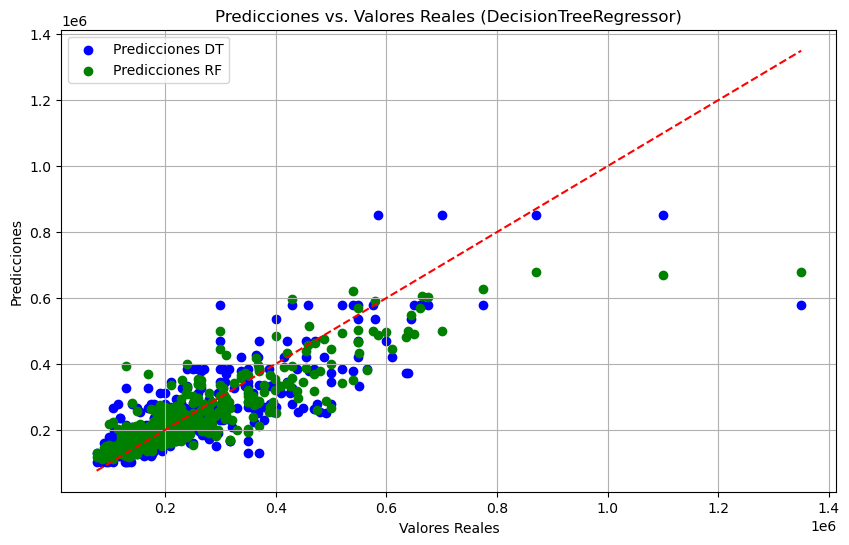

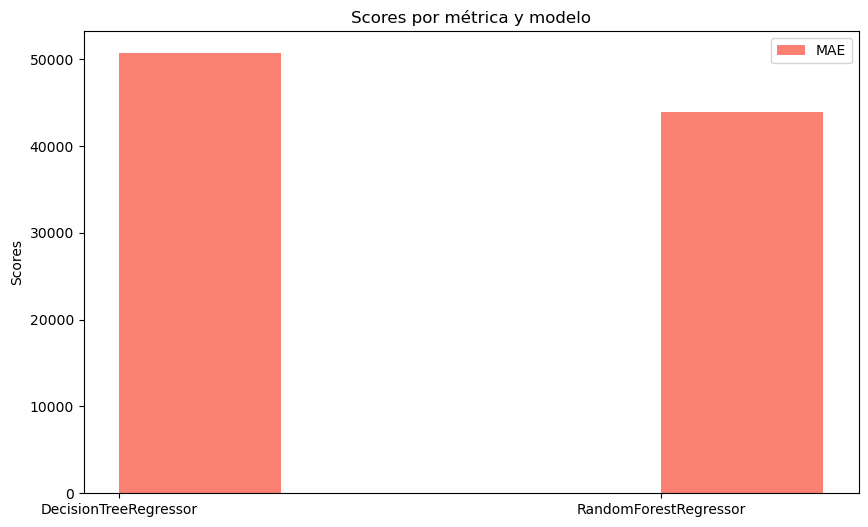

In [85]:
import matplotlib.pyplot as plt

# Gráfico de dispersión para DecisionTreeRegressor
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_predictions, color='blue', label='Predicciones DT')
plt.scatter(y_test, rf_predictions, color='green', label='Predicciones RF')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicciones vs. Valores Reales (DecisionTreeRegressor)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de barras para comparar los errores
labels = ['DecisionTreeRegressor', 'RandomForestRegressor']
mae_scores = [dt_mae, rf_mae]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))
rects2 = ax.bar(x + width/2, mae_scores, width, label='MAE', color='salmon')

ax.set_ylabel('Scores')
ax.set_title('Scores por métrica y modelo')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

Podemos ver que los puntos verdes, es decir, los valores predichos por el modelo de random forest se ajusta más a la linea de valores reales que los puntos azules, es decir, los valores de decission tree regressor.

A continuación vemos la importancia que tiene cada variable en los dos modelos. Primero el de Random Forest:

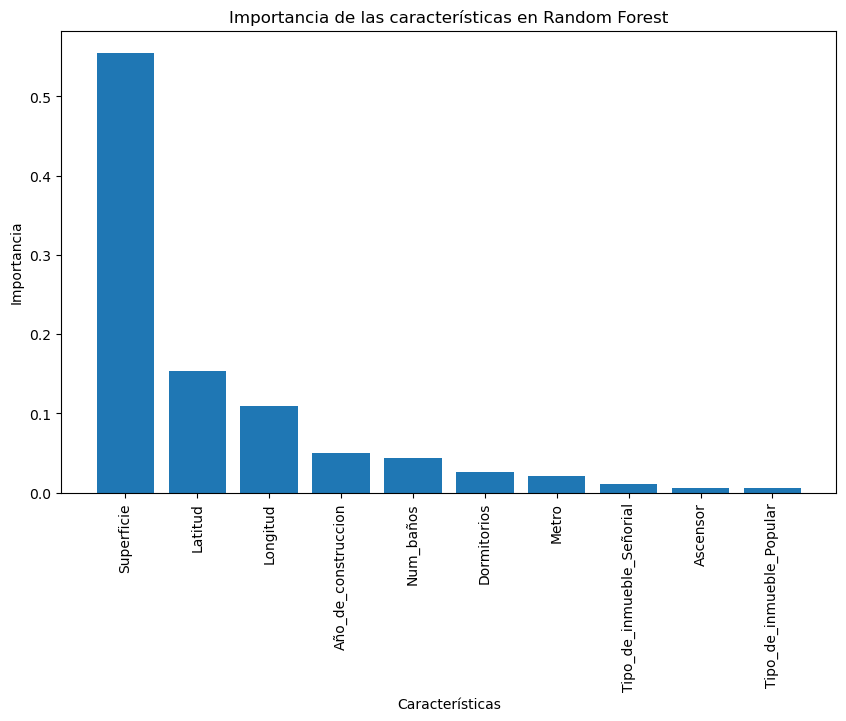

In [86]:
importances = best_random_forest.feature_importances_
# Obtener los nombres de las características
feature_names = X_train_encoded_scaled.columns

# Ordenar las importancias y los nombres de las características de manera descendente
indices = np.argsort(importances)[::-1]
importances_sorted = importances[indices]
feature_names_sorted = feature_names[indices]
importances_top10 = importances_sorted[:10]
feature_names_top10 = feature_names_sorted[:10]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_top10)), importances_top10, align='center')
plt.xticks(range(len(importances_top10)), feature_names_top10, rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características en Random Forest')
plt.show()

Y a continuación en el modelo de Decission Tree Regressor:

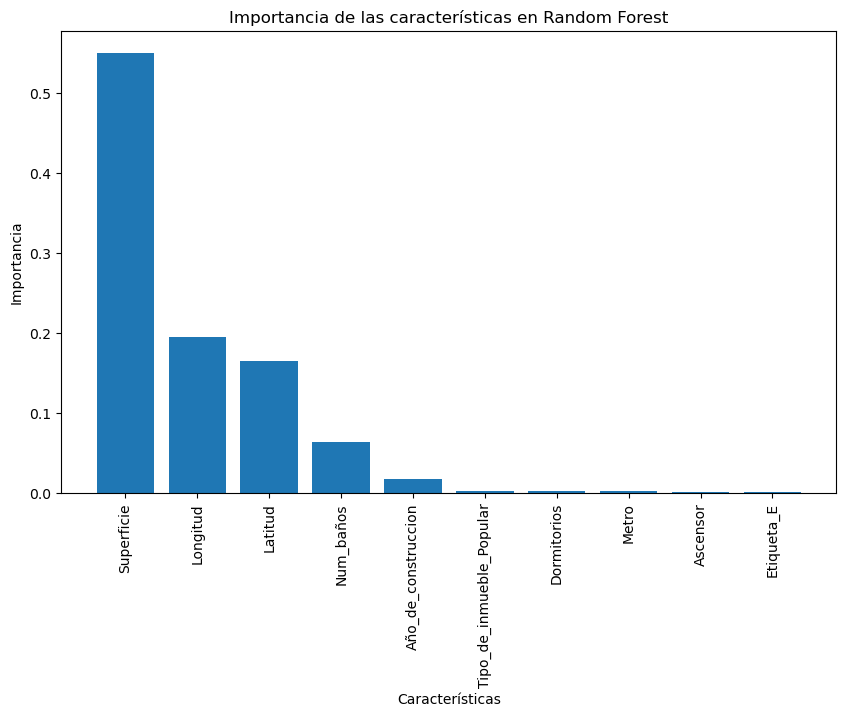

In [87]:
importances = best_decission_tree_regressor.feature_importances_
# Obtener los nombres de las características
feature_names = X_train_encoded_scaled.columns

# Ordenar las importancias y los nombres de las características de manera descendente
indices = np.argsort(importances)[::-1]
importances_sorted = importances[indices]
feature_names_sorted = feature_names[indices]
importances_top10 = importances_sorted[:10]
feature_names_top10 = feature_names_sorted[:10]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_top10)), importances_top10, align='center')
plt.xticks(range(len(importances_top10)), feature_names_top10, rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características en Random Forest')
plt.show()